In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('variables.csv')

In [ ]:
# df['Epic_week'] = pd.to_datetime(df['Epic_week'] + '_1', format='%Y_%U_%w')

# # set the 'Epic_week_adm' column as the index
# df = df.set_index('Epic_week')

# # convert the index to week-based format
# df.index = df.index.strftime('%Y_%U')

In [ ]:
df = df.drop(columns=['Epic_week'])
df

,Infectious and Parasitic Diseases,Respiratory Infection,Daily_Rainfall_Total_mm,Mean_Mean_Temperature_C,Mean_Maximum_Temperature_C,Mean_Minimum_Temperature_C,Mean_Mean_Wind_Speed_kmh,Mean_Max_Wind_Speed_kmh
0,1306,1437,20.071978,25.928571,30.197143,23.482857,7.731429,29.228571
1,1209,1370,33.892308,25.142857,27.951429,23.020000,10.257143,32.971429
2,1115,1636,6.319780,26.700000,31.654286,23.760000,7.605714,27.971429
3,1083,1785,1.977473,26.930952,31.360000,24.002857,13.591429,32.157143
4,1340,2244,0.655495,27.189286,31.737143,24.214286,14.111429,34.242857
...,...,...,...,...,...,...,...,...
673,1711,2694,8.778947,27.619328,31.300877,24.605430,6.638137,33.339474
674,1389,2224,9.319298,27.169853,31.748693,24.728945,6.130859,27.621055
675,1621,2712,10.119799,27.022111,31.144712,24.709489,6.675198,30.162873
676,1749,2801,4.597494,27.792700,32.482527,25.137852,7.526247,30.939678


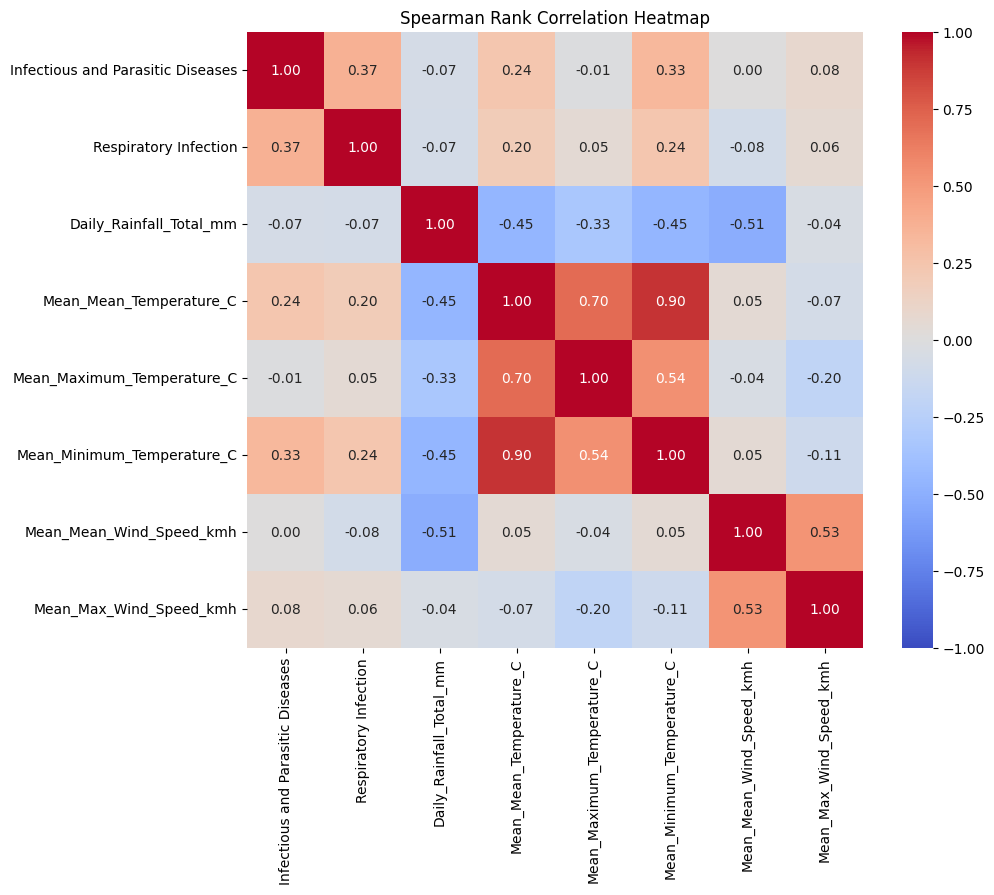

In [ ]:
corr_matrix = df.corr(method='spearman')

plt.figure(figsize=(10, 8))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt='.2f')
plt.title('Spearman Rank Correlation Heatmap')
plt.show()

In [ ]:
# create lagged features for multivariate time series data
def create_lagged_features(data, n_in=1, n_out=1, dropna=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    
    # Create lagged features for all variables (X)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # Create lagged features only for the first column (y)
    for i in range(0, n_out):
        cols.append(df.iloc[:, 0].shift(-i))
    
    agg = pd.concat(cols, axis=1)
    
    if dropna:
        agg.dropna(inplace=True)
    
    return agg.values


n_lag = 4

n_steps = 2

# Create lagged features
data_lagged = create_lagged_features(df, n_in=n_lag, n_out=n_steps)

# Separate features (X) and labels (y)
X = data_lagged[:, :-n_steps]
y = data_lagged[:, -n_steps:]

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
X_test.shape[0]

135

In [ ]:
# X = pd.DataFrame(X) # this is only for us to have a better understanding. No need to convert array to dataframe
# X

In [ ]:
# y = pd.DataFrame(y)
# y

In [ ]:
# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and test sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest

In [ ]:
# Create the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print('Mean Squared Error for each step:', mse)

Mean Squared Error for each step: [19018.18849111 26737.5593    ]


In [ ]:
y_pred = y_pred.reshape(-1,n_steps)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(y_test[:, n_steps-1], y_pred[:, n_steps-1])

print('Mean Absolute Percentage Error for {} step: {:.2f}%'.format(n_steps,mape))

Mean Absolute Percentage Error for 2 step: 9.12%


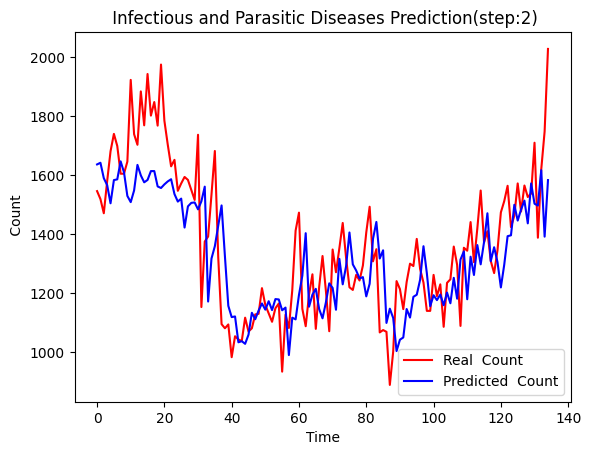

In [ ]:
plt.plot(y_test[:, n_steps-1], color = 'red', label = 'Real  Count')
plt.plot(y_pred[:, n_steps-1], color = 'blue', label = 'Predicted  Count')
plt.title(' Infectious and Parasitic Diseases Prediction(step:{})'.format(n_steps))
plt.xlabel('Time')
plt.ylabel(' Count')
plt.legend()
plt.show()

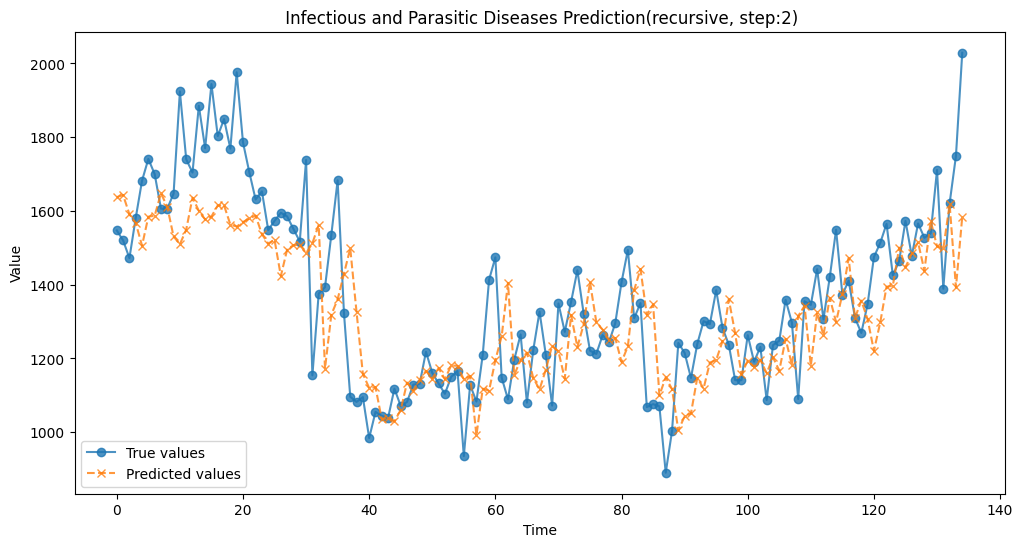

In [ ]:
def plot_predictions(y_true, y_pred, n_steps):

      plt.figure(figsize=(12, 6))
      plt.plot(y_true[:, n_steps-1], label=f'True values', linestyle='-', marker='o', alpha=0.8)
      plt.plot(y_pred[:, n_steps-1], label=f'Predicted values', linestyle='--', marker='x', alpha=0.8)

      plt.title(' Infectious and Parasitic Diseases Prediction(recursive, step:{})'.format(n_steps))
      plt.xlabel('Time')
      plt.ylabel('Value')
      plt.legend()
      plt.show()

plot_predictions(y_test, y_pred, n_steps)

### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train[:, n_steps-1])
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test[:, n_steps-1], y_pred)
print('Mean Squared Error for the last step:', mse)

mape = mean_absolute_percentage_error(y_test[:, n_steps-1], y_pred)
print('Mean Absolute Percentage Error for {} step: {:.2f}%'.format(n_steps, mape))

Mean Squared Error for the last step: 30101.97726145455
Mean Absolute Percentage Error for 2 step: 9.70%


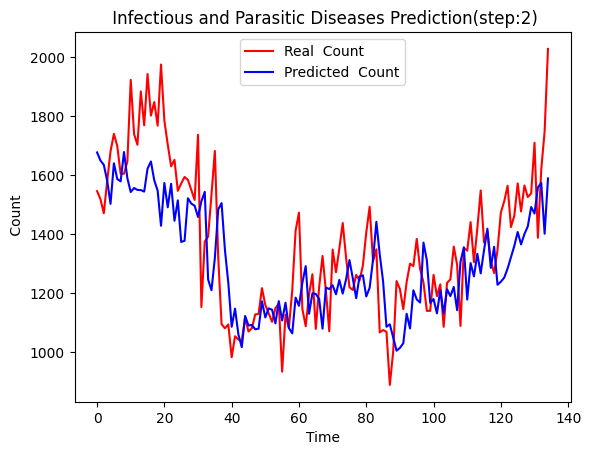

In [ ]:
plt.plot(y_test[:, n_steps-1], color = 'red', label = 'Real  Count')
plt.plot(y_pred, color = 'blue', label = 'Predicted  Count')
plt.title(' Infectious and Parasitic Diseases Prediction(step:{})'.format(n_steps))
plt.xlabel('Time')
plt.ylabel(' Count')
plt.legend()
plt.show()

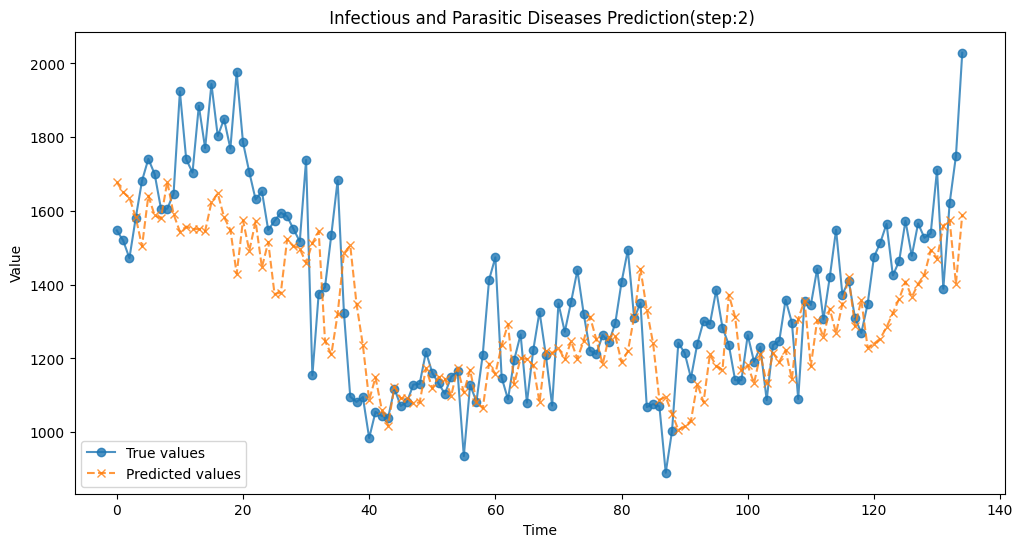

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, n_steps-1], label='True values', linestyle='-', marker='o', alpha=0.8)
plt.plot(y_pred, label='Predicted values', linestyle='--', marker='x', alpha=0.8)
plt.title(' Infectious and Parasitic Diseases Prediction(step:{})'.format(n_steps))
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### CV

Cross validation for RF

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
total_mape = 0
total_mse = 0

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test[:, n_steps-1], y_pred[:, n_steps-1])
    y_pred = y_pred.reshape(-1, n_steps)

    mape = mean_absolute_percentage_error(y_test[:, n_steps-1], y_pred[:, n_steps-1])

    print('Cross-Validation fold {}:'.format(i + 1))
    print('Mean Squared Error: {:.2f}'.format(mse))
    print('Mean Absolute Percentage Error for {} step: {:.2f}%'.format(n_steps, mape))
    print()

    total_mape += mape
    total_mse += mse

average_mape = total_mape / tscv.n_splits
average_mse = total_mse / tscv.n_splits

print('Average Mean Squared Error: {:.2f}'.format(average_mse))
print('Average Mean Absolute Percentage Error for {} step: {:.2f}%'.format(n_steps, average_mape))

Cross-Validation fold 1:
Mean Squared Error: 14288.42
Mean Absolute Percentage Error for 2 step: 9.25%

Cross-Validation fold 2:
Mean Squared Error: 16635.47
Mean Absolute Percentage Error for 2 step: 7.95%

Cross-Validation fold 3:
Mean Squared Error: 48878.35
Mean Absolute Percentage Error for 2 step: 10.97%

Cross-Validation fold 4:
Mean Squared Error: 24334.93
Mean Absolute Percentage Error for 2 step: 8.12%

Cross-Validation fold 5:
Mean Squared Error: 25150.36
Mean Absolute Percentage Error for 2 step: 9.45%

Average Mean Squared Error: 25857.51
Average Mean Absolute Percentage Error for 2 step: 9.15%


Cross validation for GB

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
total_mape = 0
total_mse = 0

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = GradientBoostingRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train[:, n_steps-1])

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[:, n_steps-1], y_pred)

    mape = mean_absolute_percentage_error(y_test[:, n_steps-1], y_pred)

    print('Cross-Validation fold {}:'.format(i + 1))
    print('Mean Squared Error: {:.2f}'.format(mse))
    print('Mean Absolute Percentage Error for {} step: {:.2f}%'.format(n_steps, mape))
    print()

    total_mape += mape
    total_mse += mse

average_mape = total_mape / tscv.n_splits
average_mse = total_mse / tscv.n_splits

print('Average Mean Squared Error: {:.2f}'.format(average_mse))
print('Average Mean Absolute Percentage Error for {} step: {:.2f}%'.format(n_steps, average_mape))

Cross-Validation fold 1:
Mean Squared Error: 14308.25
Mean Absolute Percentage Error for 2 step: 9.46%

Cross-Validation fold 2:
Mean Squared Error: 20858.53
Mean Absolute Percentage Error for 2 step: 9.09%

Cross-Validation fold 3:
Mean Squared Error: 49663.33
Mean Absolute Percentage Error for 2 step: 11.03%

Cross-Validation fold 4:
Mean Squared Error: 25054.75
Mean Absolute Percentage Error for 2 step: 8.02%

Cross-Validation fold 5:
Mean Squared Error: 27827.01
Mean Absolute Percentage Error for 2 step: 9.92%

Average Mean Squared Error: 27542.37
Average Mean Absolute Percentage Error for 2 step: 9.50%


In [ ]:
X = pd.DataFrame(X) # this is only for us to have a better understanding. No need to convert array to dataframe
X

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1306.0,1437.0,20.071978,25.928571,30.197143,23.482857,7.731429,29.228571,1209.0,1370.0,...,7.605714,27.971429,1083.0,1785.0,1.977473,26.930952,31.360000,24.002857,13.591429,32.157143
1,1209.0,1370.0,33.892308,25.142857,27.951429,23.020000,10.257143,32.971429,1115.0,1636.0,...,13.591429,32.157143,1340.0,2244.0,0.655495,27.189286,31.737143,24.214286,14.111429,34.242857
2,1115.0,1636.0,6.319780,26.700000,31.654286,23.760000,7.605714,27.971429,1083.0,1785.0,...,14.111429,34.242857,1090.0,1656.0,8.457143,26.619048,30.994286,23.805714,13.171429,34.471429
3,1083.0,1785.0,1.977473,26.930952,31.360000,24.002857,13.591429,32.157143,1340.0,2244.0,...,13.171429,34.471429,1035.0,1822.0,4.996703,27.528571,32.817143,24.357143,10.274286,31.171429
4,1340.0,2244.0,0.655495,27.189286,31.737143,24.214286,14.111429,34.242857,1090.0,1656.0,...,10.274286,31.171429,941.0,1747.0,0.488462,27.570238,31.917143,24.865714,14.982857,37.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,1573.0,2005.0,6.504433,28.043697,32.371429,25.171220,6.144277,30.489140,1478.0,2036.0,...,6.430217,28.495459,1527.0,2250.0,13.983459,27.262395,31.254715,24.052484,5.828095,33.836456
669,1478.0,2036.0,7.486751,27.179517,31.348985,24.913121,6.214541,30.552703,1566.0,2262.0,...,5.828095,33.836456,1539.0,2642.0,9.747619,27.288445,31.442275,24.103963,6.347265,30.392172
670,1566.0,2262.0,11.262406,27.509261,31.939201,24.770744,6.430217,28.495459,1527.0,2250.0,...,6.347265,30.392172,1711.0,2694.0,8.778947,27.619328,31.300877,24.605430,6.638137,33.339474
671,1527.0,2250.0,13.983459,27.262395,31.254715,24.052484,5.828095,33.836456,1539.0,2642.0,...,6.638137,33.339474,1389.0,2224.0,9.319298,27.169853,31.748693,24.728945,6.130859,27.621055


In [ ]:
y = pd.DataFrame(y) # this is only for us to have a better understanding. No need to convert array to dataframe
y

,0,1
0,1340.0,1090.0
1,1090.0,1035.0
2,1035.0,941.0
3,941.0,1039.0
4,1039.0,1025.0
...,...,...
668,1539.0,1711.0
669,1711.0,1389.0
670,1389.0,1621.0
671,1621.0,1749.0
